In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
from __future__ import division  #needed for eval to divide fractions to float instead of integer default of Python v<3

%matplotlib inline
plt.style.use = 'default'
plt.rcParams['figure.figsize'] = (4, 4)

### Import data files

In [2]:
path = 'data/'
filenameC_LC = 'postSurvey_orderLC_dataC.csv'
filenameL_LC = 'postSurvey_orderLC_dataL.csv'
filenameC_CL = 'postSurvey_orderCL_dataC.csv'
filenameL_CL = 'postSurvey_orderCL_dataL.csv'
filenameL_ans = 'postSurvey_L_answerKey.csv'
filenameC_ans = 'postSurvey_C_answerKey.csv'

dfC_LC_raw = pd.read_csv(path + filenameC_LC, delimiter='\t', encoding='utf-16')
dfC_CL_raw = pd.read_csv(path + filenameC_CL, delimiter='\t', encoding='utf-16')
dfL_LC_raw = pd.read_csv(path + filenameL_LC, delimiter='\t', encoding='utf-16')
dfL_CL_raw = pd.read_csv(path + filenameL_CL, delimiter='\t', encoding='utf-16')
dfL_ans_raw = pd.read_csv(path + filenameL_ans, delimiter='\t', encoding='utf-16')
dfC_ans_raw = pd.read_csv(path + filenameC_ans, delimiter='\t', encoding='utf-16')

In [113]:
print list(dfC_LC_raw)
print dfC_LC_raw.dtypes

[u'Status', u'Internal ID', u'Language', u'Created At', u'Updated At', u'Location', u'Username', u'GET Variables', u'Referrer', u'Number of Saves', u'Weighted Score', u'Completion Time', u'Page 1 | Time on Page', u'Page 2 | Time on Page', u'Page 3 | Time on Page', u'Page 4 | Time on Page', u'Page 5 | Time on Page', u'Page 6 | Time on Page', u'Page 7 | Time on Page', u'Page 8 | Time on Page', u'Page 9 | Time on Page', u'IP Address', u'Invite Code', u'Invite Email', u'Invite Name', u'Collector', u'[id] Please write your assigned #: \xa0 \xa0 \xa0 \xa0 \xa0   \xa0', u'[perceivedvalue.0] For me personally, the virtual lab activity I just did was... | boring', u'[perceivedvalue.1] For me personally, the virtual lab activity I just did was... | productive', u'[perceivedvalue.2] For me personally, the virtual lab activity I just did was... | useless', u'[perceivedvalue.3] For me personally, the virtual lab activity I just did was... | engaging', u'[taskinterpretation.0] In the virtual lab act

### Filter out only post-assessment data and rename columns

In [185]:
def filter_df( df, pattern, new_headers ):
    headers = list(df)
    filtered_headers = [header for header in headers if re.search(pattern, header)]
    df2 = df.loc[:, filtered_headers]  
    newcolnames = {header : new_header for (header, new_header) in zip(filtered_headers, new_headers)}
    df2.rename(columns=newcolnames, inplace=True)
    return df2

#pick out only column that match student ID, qual or quant questions
other_pattern = '\[id\]'
qual_pattern = '\[qual[0-9]\]'
quant_pattern = '\[quant\.[0-9]'  #specify number in regex only needed in case we only want certain specific Qs
pattern = other_pattern + '|' + qual_pattern + '|' + quant_pattern

#pick out new names for the columns that will be picked from above patterns
other_colnames = ['id']
qual_colnames = ['qual1','qual2','qual3','qual4','qual5','qual6']
quant_colnames = ['quant1','quant2','quant3','quant4']
colnames = other_colnames + qual_colnames + quant_colnames

#filter and rename capacitor dataframe
dfC_LC = filter_df( dfC_LC_raw, pattern, colnames )
dfC_LC.loc[:,'condition'] = pd.Series('LC', index=dfC_LC.index) #add column for condition i.e. if C was first or last
dfC_CL = filter_df( dfC_CL_raw, pattern, colnames )
dfC_CL.loc[:,'condition'] = pd.Series('CL', index=dfC_CL.index)
dfC = pd.concat([dfC_LC, dfC_CL], ignore_index=True)
# dfC=dfC.set_index('id')  #this is for setting ID as row index
# dfC.index.name = None
print dfC.shape

#filter and rename light absorbance dataframe
dfL_LC = filter_df( dfL_LC_raw, pattern, colnames )
dfL_LC.loc[:,'condition'] = pd.Series('LC', index=dfL_LC.index) #add column for condition i.e. if L was first or last
dfL_CL = filter_df( dfL_CL_raw, pattern, colnames )
dfL_CL.loc[:,'condition'] = pd.Series('CL', index=dfL_CL.index)
dfL = pd.concat([dfL_LC, dfL_CL], ignore_index=True)
# dfL=dfL.set_index('id')  #this is for setting ID as row index
# dfL.index.name = None
print dfL.shape

#filter and rename answer key dataframes
dfC_quant_ans = filter_df( dfC_ans_raw, quant_pattern, quant_colnames )
dfC_qual_ans = filter_df( dfC_ans_raw, qual_pattern, qual_colnames )
dfC_ans = pd.concat([dfC_qual_ans, dfC_quant_ans], axis=1)
print dfC_ans.shape

dfL_quant_ans = filter_df( dfL_ans_raw, quant_pattern, quant_colnames )
dfL_qual_ans = filter_df( dfL_ans_raw, qual_pattern, qual_colnames )
dfL_ans = pd.concat([dfL_qual_ans, dfL_quant_ans], axis=1)
print dfL_ans.shape


# df.dtypes  #find what type is each column
# # find bad student IDs to fix  
# # need to check validity of ID --> needs to start with one, or too few characters needs to be checked.
# print set(dfC['id'])-set(dfL['id']) 
# print set(dfL['id'])-set(dfC['id'])
# # this finds duplicate entries
IDcounts = Counter(list(dfL['id']))
duplicates=[ID for ID in IDcounts if IDcounts[ID]>1]
# dfL[ dfL['id'] == duplicates ]  #examine duplicates
# dfL.set_value(73, 'id', 23784336) #change ID for one of the duplicates assuming different dates.
dfL = dfL[ dfL['id'] != duplicates ] #remove duplicates
# dfL.reset_index(level=0, drop=True)
dfC = dfC[ dfC['id'] != duplicates ] #remove duplicates
# dfC.reset_index(level=0, drop=True) #reset index after dropping duplicates
#dfL.drop_duplicates(...)  could also use this method

# # merge C and L results in one dataframe
# df = pd.merge(dfC, dfL, on=['id','condition'], how='outer', suffixes=('_C', '_L'))
# # move condition column before data results
# cols = list(df)
# cols.remove('condition')
# cols.insert(1, 'condition')
# df = df[cols]
# df['id'] = df['id'].astype(int) # <-- this shouldn't be needed but check!
# # create new column for bad IDs that were fixed so that we can track with sim + handouts
# # df.loc[:,'id_flag'] = pd.Series(0, index=df.index)
# # for student in flag_student_IDs:
# #     df[df['id']==student]['id_flag']=1 



(107, 12)
(107, 12)
(1, 10)
(1, 10)


In [164]:
def create_year_column( df, years ):
    headers = list(df)
    for year in years:  #this is ugly/slow must be a better way 
        for header in headers:
            if re.search('\[year\].*' + year, header):
                idx = df[ df[header] == 1 ].index.tolist()
                df.set_value(idx, 'year', year)
        
years = ['1','2','3','4','5','6','Mast','Doct']

#pick out only column that match student ID, qual or quant questions
some_pattern = '\[major\]|\[year\]'

#pick out new names for the columns that will be picked from above patterns
year_colnames = ['[year] ' + year for year in years]
some_colnames = ['major'] + year_colnames
df_demo = filter_df( dfL_CL_raw, some_pattern, some_colnames )
create_year_column( df_demo, years )
df_demo

major  [year] 1  [year] 2  [year] 3  \
0                    Computer Engineering       1.0       NaN       NaN   
1                             *Undeclared       1.0       NaN       NaN   
2                             *Undeclared       1.0       NaN       NaN   
3                       Civil Engineering       1.0       NaN       NaN   
4                            Food Science       1.0       NaN       NaN   
5                                 Biology       NaN       NaN       1.0   
6                     Engineering Physics       1.0       NaN       NaN   
7                       Civil Engineering       1.0       NaN       NaN   
8                             *Undeclared       1.0       NaN       NaN   
9                             *Undeclared       1.0       NaN       NaN   
10                            *Undeclared       1.0       NaN       NaN   
11                       Computer Science       NaN       NaN       1.0   
12                       Computer Science       1.0       NaN       NaN   
13                                Geology       NaN       1.0       NaN   
14                        General Science       1.0       NaN       NaN   
15                            *Undeclared       1.0       NaN       NaN   
16                            *Undeclared       1.0       NaN       NaN   
17                   Chemical Engineering       1.0       NaN       NaN   
18                 Earth & Ocean Sciences       1.0       NaN       NaN   
19                            *Undeclared       1.0       NaN       NaN   
20                       Computer Science       1.0       NaN       NaN   
21                       Computer Science       1.0       NaN       NaN   
22                            *Undeclared       1.0       NaN       NaN   
23                       Computer Science       1.0       NaN       NaN   
24                            *Undeclared       1.0       NaN       NaN   
25                       Computer Science       NaN       NaN       1.0   
26      Chemical & Biological Engineering       1.0       NaN       NaN   
27                 Mechanical Engineering       1.0       NaN       NaN   
28                            *Undeclared       1.0       NaN       NaN   
29                            *Undeclared       1.0       NaN       NaN   
30                                Biology       NaN       1.0       NaN   
31                              Economics       NaN       NaN       NaN   
32  *Non science or applied science major       1.0       NaN       NaN   
33                            *Undeclared       1.0       NaN       NaN   
34                                Biology       NaN       1.0       1.0   
35                            Mathematics       NaN       1.0       NaN   
36                            *Undeclared       1.0       NaN       NaN   
37                            *Undeclared       1.0       NaN       NaN   
38                            *Undeclared       1.0       NaN       NaN   
39                            *Undeclared       1.0       NaN       NaN   
40                            *Undeclared       1.0       NaN       NaN   
41                            *Undeclared       1.0       NaN       NaN   
42                            *Undeclared       1.0       NaN       NaN   
43               Food, Nutrition & Health       1.0       NaN       NaN   
44                            *Undeclared       NaN       1.0       NaN   
45  *Non science or applied science major       NaN       1.0       NaN   
46                            *Undeclared       1.0       NaN       NaN   

    [year] 4  [year] 5  [year] 6  [year] Mast  [year] Doct year  
0        NaN       NaN       NaN          NaN          NaN    1  
1        NaN       NaN       NaN          NaN          NaN    1  
2        NaN       NaN       NaN          NaN          NaN    1  
3        NaN       NaN       NaN          NaN          NaN    1  
4        NaN       NaN       NaN          NaN          NaN    1  
5        NaN       NaN       NaN       

In [184]:
def what_is_year ( row, *years ):
    cols = row.index
    for year, col in zip(years, cols):
        if row[col]==1:
            return year

df_demo2 = filter_df( dfL_CL_raw, some_pattern, some_colnames )
df_demo2.loc[:,'year'] = df_demo2[ year_colnames ].apply(what_is_year, axis=1, args=years)
df_demo2

major  [year] 1  [year] 2  [year] 3  \
0                    Computer Engineering       1.0       NaN       NaN   
1                             *Undeclared       1.0       NaN       NaN   
2                             *Undeclared       1.0       NaN       NaN   
3                       Civil Engineering       1.0       NaN       NaN   
4                            Food Science       1.0       NaN       NaN   
5                                 Biology       NaN       NaN       1.0   
6                     Engineering Physics       1.0       NaN       NaN   
7                       Civil Engineering       1.0       NaN       NaN   
8                             *Undeclared       1.0       NaN       NaN   
9                             *Undeclared       1.0       NaN       NaN   
10                            *Undeclared       1.0       NaN       NaN   
11                       Computer Science       NaN       NaN       1.0   
12                       Computer Science       1.0       NaN       NaN   
13                                Geology       NaN       1.0       NaN   
14                        General Science       1.0       NaN       NaN   
15                            *Undeclared       1.0       NaN       NaN   
16                            *Undeclared       1.0       NaN       NaN   
17                   Chemical Engineering       1.0       NaN       NaN   
18                 Earth & Ocean Sciences       1.0       NaN       NaN   
19                            *Undeclared       1.0       NaN       NaN   
20                       Computer Science       1.0       NaN       NaN   
21                       Computer Science       1.0       NaN       NaN   
22                            *Undeclared       1.0       NaN       NaN   
23                       Computer Science       1.0       NaN       NaN   
24                            *Undeclared       1.0       NaN       NaN   
25                       Computer Science       NaN       NaN       1.0   
26      Chemical & Biological Engineering       1.0       NaN       NaN   
27                 Mechanical Engineering       1.0       NaN       NaN   
28                            *Undeclared       1.0       NaN       NaN   
29                            *Undeclared       1.0       NaN       NaN   
30                                Biology       NaN       1.0       NaN   
31                              Economics       NaN       NaN       NaN   
32  *Non science or applied science major       1.0       NaN       NaN   
33                            *Undeclared       1.0       NaN       NaN   
34                                Biology       NaN       1.0       1.0   
35                            Mathematics       NaN       1.0       NaN   
36                            *Undeclared       1.0       NaN       NaN   
37                            *Undeclared       1.0       NaN       NaN   
38                            *Undeclared       1.0       NaN       NaN   
39                            *Undeclared       1.0       NaN       NaN   
40                            *Undeclared       1.0       NaN       NaN   
41                            *Undeclared       1.0       NaN       NaN   
42                            *Undeclared       1.0       NaN       NaN   
43               Food, Nutrition & Health       1.0       NaN       NaN   
44                            *Undeclared       NaN       1.0       NaN   
45  *Non science or applied science major       NaN       1.0       NaN   
46                            *Undeclared       1.0       NaN       NaN   

    [year] 4  [year] 5  [year] 6  [year] Mast  [year] Doct year  
0        NaN       NaN       NaN          NaN          NaN    1  
1        NaN       NaN       NaN          NaN          NaN    1  
2        NaN       NaN       NaN          NaN          NaN    1  
3        NaN       NaN       NaN          NaN          NaN    1  
4        NaN       NaN       NaN          NaN          NaN    1  
5        NaN       NaN       NaN       

In [4]:
dfC_ans.dtypes

qual1      object
qual2      object
qual3      object
qual4      object
qual5      object
qual6      object
quant1    float64
quant2    float64
quant3      int64
quant4    float64
dtype: object

### Grade qual questions

In [6]:
#create grading function for qualitative Qs
def grade_qual_questions( df, df_ans, questions, id_header, ReportWrong = False ):
    students = df[id_header]
    for student in students:
        for question in questions:
            idx = df[df['id']==student].index.tolist()[0]
            if df.loc[idx][question] == df_ans.loc[0][question]:
                df.set_value(idx, question + '_score', 1)
            else:
                df.set_value(idx, question + '_score', 0)
                if ReportWrong:
                    print question, student
                    print df[df['id']==student][question].values
                    print df_ans[question].values, '\n'

grade_qual_questions( dfL, dfL_ans, qual_colnames, 'id' )
grade_qual_questions( dfC, dfC_ans, qual_colnames, 'id' )

In [7]:
dfL.head()

id                                              qual1  \
0  12818156  high concentration (https://survey.ubc.ca/medi...   
1  11200165  high concentration (https://survey.ubc.ca/medi...   
2  77047160  high concentration (https://survey.ubc.ca/medi...   
3  64006159  low concentration (https://survey.ubc.ca/media...   
4  27451164  high concentration (https://survey.ubc.ca/medi...   

                                               qual2  \
0  high concentration, low volume (https://survey...   
1   (https://survey.ubc.ca/media/assets/groups/54...   
2  high concentration, low volume (https://survey...   
3  low concentration, high volume (https://survey...   
4  high concentration, low volume (https://survey...   

                                               qual3  \
0  big beaker (https://survey.ubc.ca/media/assets...   
1  big beaker (https://survey.ubc.ca/media/assets...   
2  big beaker (https://survey.ubc.ca/media/assets...   
3  small beaker (https://survey.ubc.ca/media/asse...   
4  big beaker (https://survey.ubc.ca/media/assets...   

                                               qual4  \
0   (https://survey.ubc.ca/media/assets/groups/54...   
1   (https://survey.ubc.ca/media/assets/groups/54...   
2   (https://survey.ubc.ca/media/assets/groups/54...   
3   (https://survey.ubc.ca/media/assets/groups/54...   
4   (https://survey.ubc.ca/media/assets/groups/54...   

                                               qual5  \
0   (https://survey.ubc.ca/media/assets/groups/54...   
1   (https://survey.ubc.ca/media/assets/groups/54...   
2  angled laser beam (https://survey.ubc.ca/media...   
3   (https://survey.ubc.ca/media/assets/groups/54...   
4   (https://survey.ubc.ca/media/assets/groups/54...   

                                               qual6            quant1  \
0  red laser beam (https://survey.ubc.ca/media/as...               0.1   
1  red laser beam (https://survey.ubc.ca/media/as...               0.1   
2  red laser beam (https://survey.ubc.ca/media/as...               0.1   
3  blue laser beam (https://survey.ubc.ca/media/a...  highrer than 0.2   
4  red laser beam (https://survey.ubc.ca/media/as...               0.1   

           quant2          quant3          quant4 condition  qual1_score  \
0             0.4             0.8             0.2        LC          1.0   
1             0.4             0.4             0.2        LC          1.0   
2             0.4             0.8             0.2        LC          1.0   
3  lower than 0.2  lower than 0.2  lower than 0.2        LC          0.0   
4             0.4             0.8             0.3        LC          1.0   

   qual2_score  qual3_score  qual4_score  qual5_score  qual6_score  
0          1.0          1.0          1.0          0.0          1.0  
1          0.0          1.0          1.0          0.0          1.0  
2          1.0          1.0          1.0          1.0          1.0  
3          0.0          0.0          0.0          0.0          0.0  
4          1.0          1.0          1.0          0.0          1.0

### Grade quant questions

In [20]:
#create grading function for quant Qs
def is_number( string ):
    try:
        float( eval( re.sub('[pPcC]', '', string) )) #this evaluates fractions and strips units
        return True
    except:
        return False

def make_number( string ):
    return float( eval( re.sub('[pPcC]', '', string) ))

def grade_quant_questions( df, df_ans, questions, id_header, ReportWrong = False, ManualGrade = False ):
    students = df[id_header]
    for question in questions:
        for student in students:
            idx = df[df['id']==student].index.tolist()[0]
            student_ans = df.loc[idx][question]
            correct_ans = df_ans.loc[0][question]
            if is_number( student_ans ):
                if make_number( student_ans ) == correct_ans:
                    df.set_value(idx, question + '_score', 2)
                else:
                    df.set_value(idx, question + '_score', 0)
                    if ReportWrong:
                        print question, student
                        print student_ans, correct_ans, '\n',
            else:
                # if ManualGrade == False then no value is set and score is NaN
                if ManualGrade:
                    print question, student, '->', student_ans, '| ans =', correct_ans, '| manual score = ',
                    manual_score = input()
                    df.set_value(idx, question + '_score', manual_score)

grade_quant_questions( dfL, dfL_ans, quant_colnames, 'id', ManualGrade = True )


 quant1 64006159 -> highrer than 0.2 | ans = 0.1 | manual score = 0
 quant1 59043165 -> decrease | ans = 0.1 | manual score = 1
 quant1 89047164 -> same | ans = 0.1 | manual score = 0
 quant1 55825144 -> lower | ans = 0.1 | manual score = 1
 quant1 15072160 -> absorbance would decrease | ans = 0.1 | manual score = 1
 quant1 19562150 -> smaller | ans = 0.1 | manual score = 1
 quant1 13654167 -> double maybe | ans = 0.1 | manual score = 0
 quant1 17595160 -> less than 0.2 | ans = 0.1 | manual score = 1
 quant1 11892169 -> lower | ans = 0.1 | manual score = 1
 quant1 15444164 -> increase | ans = 0.1 | manual score = 0
 quant1 17007153 -> lower ( around 0.1) | ans = 0.1 | manual score = 1
 quant1 15188167 -> less than 0.2 | ans = 0.1 | manual score = 1
 quant1 13122150 -> 0.1?? I am not sure because I didn't finish the experiment but definately smaller than 0.2 | ans = 0.1 | manual score = 1
 quant1 26984162 -> Half the absorbance | ans = 0.1 | manual score = 2
 quant2 64006159 -> lower th

In [ ]:
dfL.head()

condition
CL    Axes(0.125,0.125;0.775x0.775)
LC    Axes(0.125,0.125;0.775x0.775)
Name: quant1_score, dtype: object

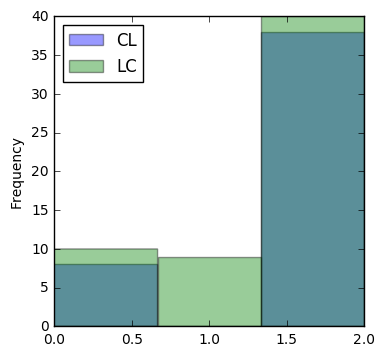

In [93]:
# print(dfL.describe())  #basic descriptive stats for each column
# dfL.hist(bins=3)  #plots set of histograms for all columns
# dfL.groupby('condition').hist(bins=3)  #plots 2 sets of histograms of each column, one set for each condition
# histogram of one column grouped by condition and overlayed
dfL.groupby('condition').quant1_score.plot.hist(bins=3,alpha=0.4,legend=True)  
# dfL.groupby('condition').count()
# dfL.groupby('condition').transform(lambda x: x / x.count())  #useful snippet to manipulate column data per condition

# making histograms directly using numpy/matplotlib for full control, e.g. normalizing frequency so to sum=1
# x1 = dfL[dfL['condition']=='CL']['quant1_score']
# x2 = dfL[dfL['condition']=='LC']['quant1_score']
# hist1, bins1 = np.histogram(x1, bins=3)
# hist2, bins2 = np.histogram(x2, bins=3)
# plt.bar(bins1[:-1], hist1 / hist1.sum(), width=(bins1[1]-bins1[0]), color='red',alpha=0.5, label='CL')
# plt.bar(bins2[:-1], hist2 / hist2.sum(), width=(bins2[1]-bins2[0]), color='blue',alpha=0.5, label='LC')
# plt.legend(loc='upper left')